In [1]:
import numpy as np
import hydra
import torch
import itertools
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from omegaconf import OmegaConf
from pytorch_lightning import (
    LightningDataModule,
    LightningModule,
    seed_everything,
)

from utils import *
from multimodal_contrastive.utils import utils

In [2]:
# register custom resolvers if not already registered
OmegaConf.register_new_resolver("sum", lambda input_list: np.sum(input_list), replace=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Load config for CLIP model
config_name = "puma_sm_gmc"
configs_path = "../../configs"

with hydra.initialize(version_base=None, config_path=configs_path):
    cfg = hydra.compose(config_name=config_name)

cfg.datamodule.split_type

'shuffled_scaffold'

In [4]:
# set seed for random number generators in pytorch, numpy and python.random
# and especially for generating the same data splits for the test set
if cfg.get("seed"):
    seed_everything(cfg.seed, workers=True)

In [5]:
# Load test data split
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.datamodule)
datamodule.setup("test")

# train_loader = datamodule.train_dataloader()
test_loader = datamodule.infer_dataloader()
val_loader = datamodule.val_dataloader()
train_idx, val_idx, test_idx = datamodule.get_split_idx()

/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Train on samples from shuffled_scaffold.
Train on 13582 samples.
Validate on 1698 samples.
Test on 1698 samples.


/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
import pickle 

n_samples = 5

# Randomly sample a single data point from the test dataset and save to disk
dataset = datamodule.dataset

for idx in range(n_samples):
    random_idx = np.random.choice(test_idx)
    sample = dataset[random_idx]

    struct = sample["inputs"]["struct"]
    smiles = struct.mols

    with open(f"sample_{idx}.pkl", "wb") as f:
        pickle.dump(sample, f)
    
    with open(f"sample_{idx}.txt", "wb") as f:
        f.write(smiles)

In [6]:
# Load model from checkpoint
# ckpt_path = "/home/mila/s/stephen.lu/gfn_gene/res/mmc/morph_struct.ckpt"
# ckpt_path = "/home/mila/s/stephen.lu/scratch/mmc/omics-guided-gfn/05tjweok/checkpoints/epoch=22-step=2438.ckpt"
ckpt_path = "/home/mila/s/stephen.lu/gfn_gene/res/mmc/morph_struct_90_step_val_loss.ckpt"
model: LightningModule = utils.instantiate_model(cfg)
model = model.load_from_checkpoint(ckpt_path, map_location=device)
model = model.eval()

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(


In [7]:
# Set which loader to use
# loader = test_loader
loader, filtered_ge_idx = test_loader, test_idx
loader = make_eval_data_loader(loader.dataset)

# Peek at the first example in the loaded set
example = next(iter(loader))
inputs = example["inputs"]
struct, morph = inputs["struct"], inputs["morph"]

print(struct)
print(morph.shape)

DataBatch(x=[4599, 133], edge_index=[2, 9942], edge_attr=[9942, 12], mols=[128], batch=[4599], ptr=[129])
torch.Size([128, 1746])


In [8]:
# Get latent representations for all test examples
representations, mols = model.compute_representation_dataloader(
    loader,
    device=device,
    return_mol=True
)

100%|██████████| 14/14 [00:07<00:00,  1.90it/s]


In [9]:
# Save representations to disk
save = False
if save:
    save_representations(mols, representations, "representations.npz")

In [10]:
# If dataset is too large, randomly subset to cutoff molecules
p_mols, p_representations, p_idx = random_subset(mols, representations, cutoff=3000)

In [11]:
p_representations["morph"].shape

(1698, 1024)

In [12]:
# Use rdkit to get Morgan fingerprints for each molecule in mols
mol_fps = get_molecular_fingerprints(p_mols, fp_type="morgan", radius=3, nbits=2048)
tanimoto_sim = get_molecular_similarity(mol_fps, "tanimoto")

100%|██████████| 1698/1698 [00:04<00:00, 420.99it/s]


In [13]:
# Get the raw domain data (gene expression & cell profiler features) from the dataloader
mods = unroll_dataloader(loader, mods=['morph'])
# ge = mods['ge'][p_idx]
morph = mods['morph'][p_idx]

100%|██████████| 14/14 [00:04<00:00,  3.20it/s]


In [14]:
# run pca on raw gene expression matrix
N_genes=30
pca = PCA(n_components=N_genes)
ge_pca = pca.fit_transform(ge)
ge_pca.shape

(1698, 30)

In [14]:
# run pca on raw morphology (Cell Profiler) features
N_morph_f = 30
pca = PCA(n_components=N_morph_f)
morph_pca = pca.fit_transform(morph)
morph_pca.shape

(1698, 30)

In [16]:
# Subset raw gene expression to top-k=81 most differentially expressed genes
filtered_ge = np.load("adata_scale_filt.npy")
filtered_ge = filtered_ge[filtered_ge_idx][p_idx]
filtered_ge.shape

(1698, 81)

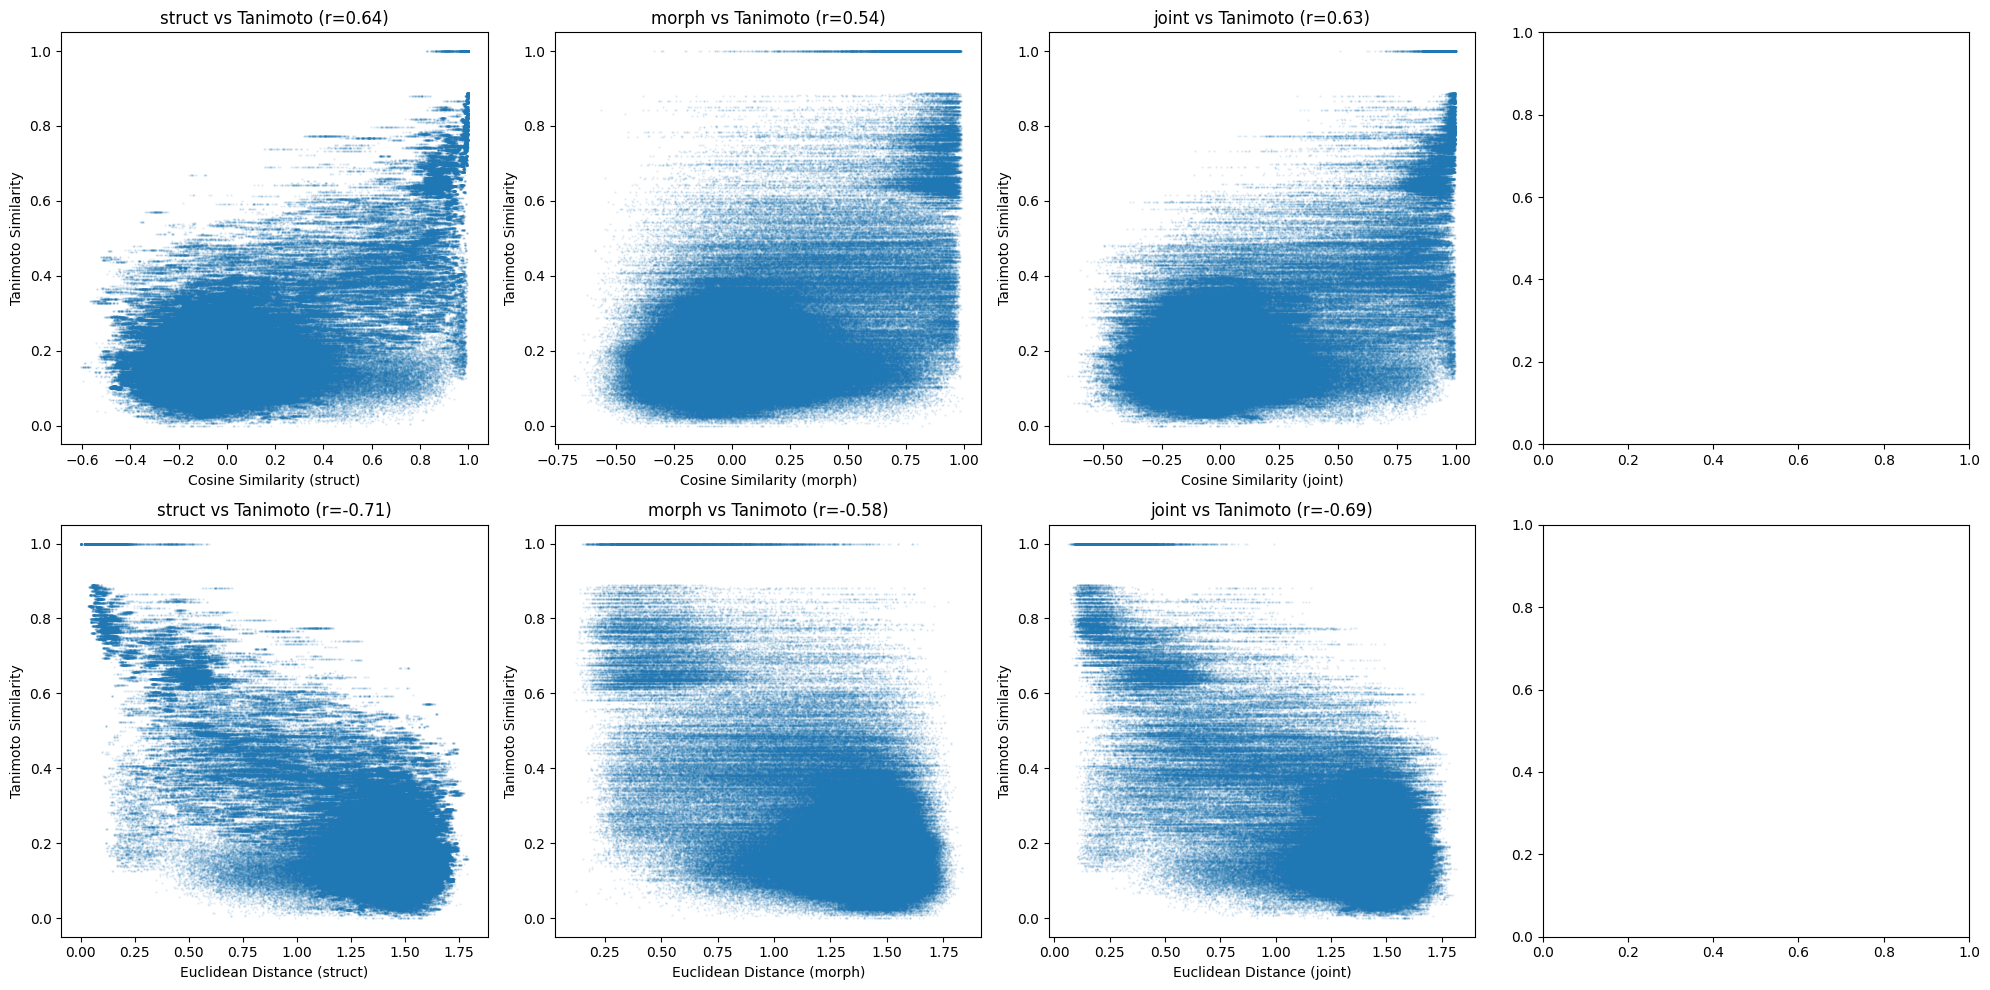

In [15]:
# Single modality latent distance versus tanimoto similarity
mods_x = ['struct', 'morph', 'joint']
mods_y = tanimoto_sim

fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for idx, mod_x in enumerate(mods_x):
    x = get_pairwise_similarity(
        p_representations[mod_x],
        p_representations[mod_x],
        metric="cosine"
    )
    x, y = get_values_from_dist_mat(x, mods_y, keep_diag=False)
    corr = np.corrcoef(x, y)

    ax[0, idx].scatter(x, y, alpha=0.1, s=.5)
    ax[0, idx].set_xlabel(f"Cosine Similarity ({mod_x})")
    ax[0, idx].set_ylabel("Tanimoto Similarity")
    ax[0, idx].set_title(f"{mod_x} vs Tanimoto (r={corr[0, 1]:.2f})")

for idx, mod_x in enumerate(mods_x):
    x = get_pairwise_similarity(
        p_representations[mod_x],
        p_representations[mod_x],
        metric="euclidean"
    )
    x, y = get_values_from_dist_mat(x, mods_y, keep_diag=False)
    corr = np.corrcoef(x, y)
    
    ax[1, idx].scatter(x, y, alpha=0.1, s=.5)
    ax[1, idx].set_xlabel(f"Euclidean Distance ({mod_x})")
    ax[1, idx].set_ylabel("Tanimoto Similarity")
    ax[1, idx].set_title(f"{mod_x} vs Tanimoto (r={corr[0, 1]:.2f})")

plt.tight_layout()
plt.savefig("single_modality_vs_tanimoto.png")
plt.show()

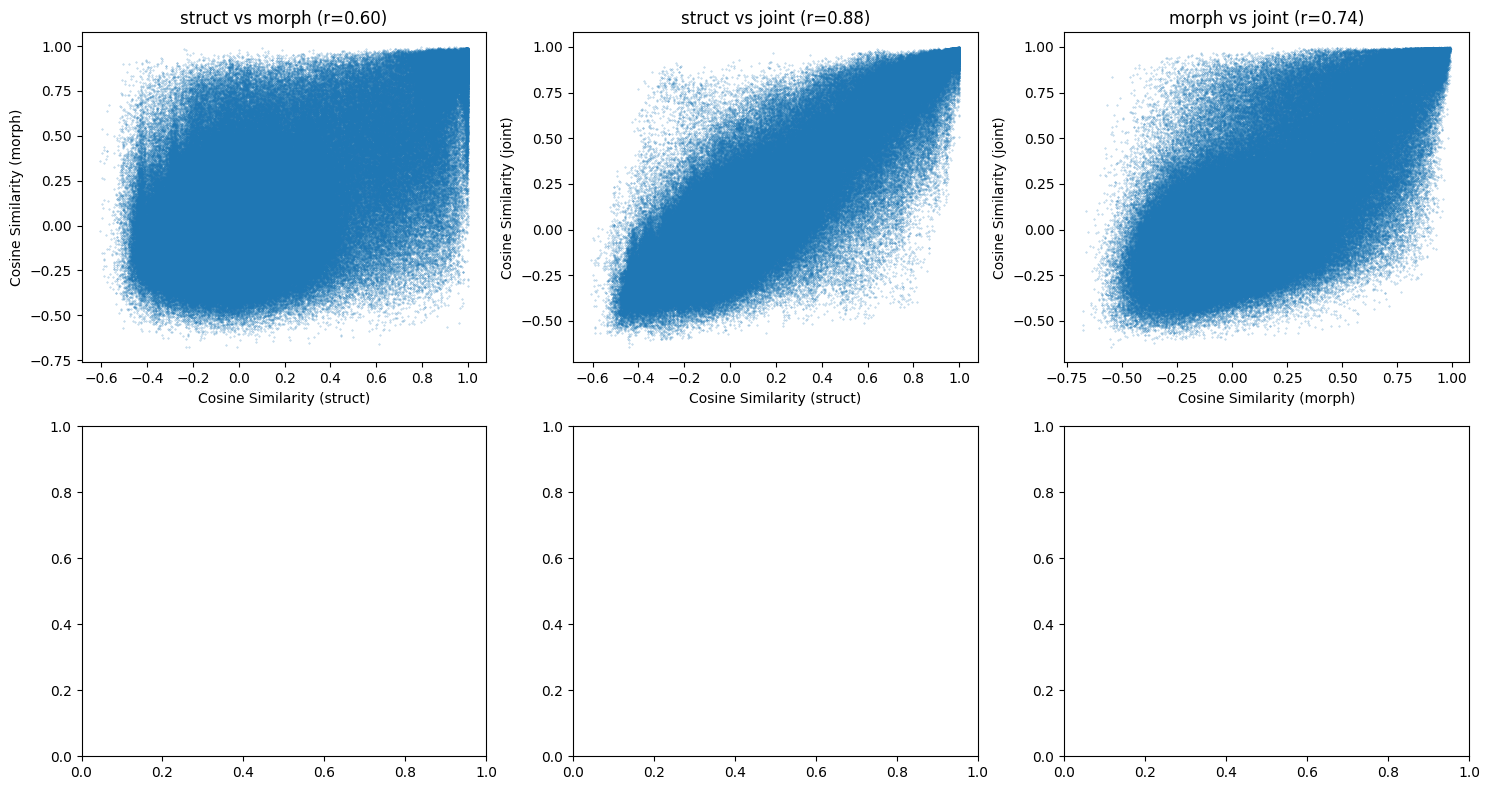

In [16]:
# plotting different modalities of the same samples against each other
mods = ['struct', 'morph', 'joint']

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ctr = 0

for idx in range(len(mods)):
    for idy in range(idx+1, len(mods)):
        x = get_pairwise_similarity(
            p_representations[mods[idx]],
            p_representations[mods[idx]],
            metric="cosine"
        )
        y = get_pairwise_similarity(
            p_representations[mods[idy]],
            p_representations[mods[idy]],
            metric="cosine"
        )
        x, y = get_values_from_dist_mat(x, y, keep_diag=False)
        corr = np.corrcoef(x, y)
        
        ax_idx = 1 if ctr >= 3 else 0

        ax[ax_idx, ctr%3].scatter(x, y, alpha=0.5, s=.1)
        ax[ax_idx, ctr%3].set_xlabel(f"Cosine Similarity ({mods[idx]})")
        ax[ax_idx, ctr%3].set_ylabel(f"Cosine Similarity ({mods[idy]})")
        ax[ax_idx, ctr%3].set_title(f"{mods[idx]} vs {mods[idy]} (r={corr[0, 1]:.2f})")
        ctr += 1
        
plt.tight_layout()
plt.savefig("single_modality_vs_single_modality.png")
plt.show()

In [ ]:
# plot cross-modality latent similarity versus raw data domain similarity (gene expression & Tanimoto sim)
mods_x = ['struct', 'ge', 'joint']
ge_sim = get_pairwise_similarity(ge, ge, metric="cosine")

fig, ax = plt.subplots(3, 3, figsize=(15, 12))

for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    x, y = get_values_from_dist_mat(x, tanimoto_sim, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[0, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[0, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[0, idx].set_ylabel("Tanimoto Similarity")
    ax[0, idx].set_title(f"({mod_a}-{mod_b}) vs Tanimoto (r={corr[0, 1]:.2f})")
    
for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = ge_sim
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[1, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[1, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[1, idx].set_ylabel("Cosine Similarity (raw gene exp)")
    ax[1, idx].set_title(f"({mod_a}-{mod_b}) vs raw GE (r={corr[0, 1]:.2f})")
    
for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = ge_sim
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[2, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[2, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[2, idx].set_ylabel("Euclidean Distance (raw gene exp)")
    ax[2, idx].set_title(f"({mod_a}-{mod_b}) vs raw GE (r={corr[0, 1]:.2f})")
        
plt.tight_layout()
plt.savefig("cross_modality_vs_raw_sim.png")
plt.show()

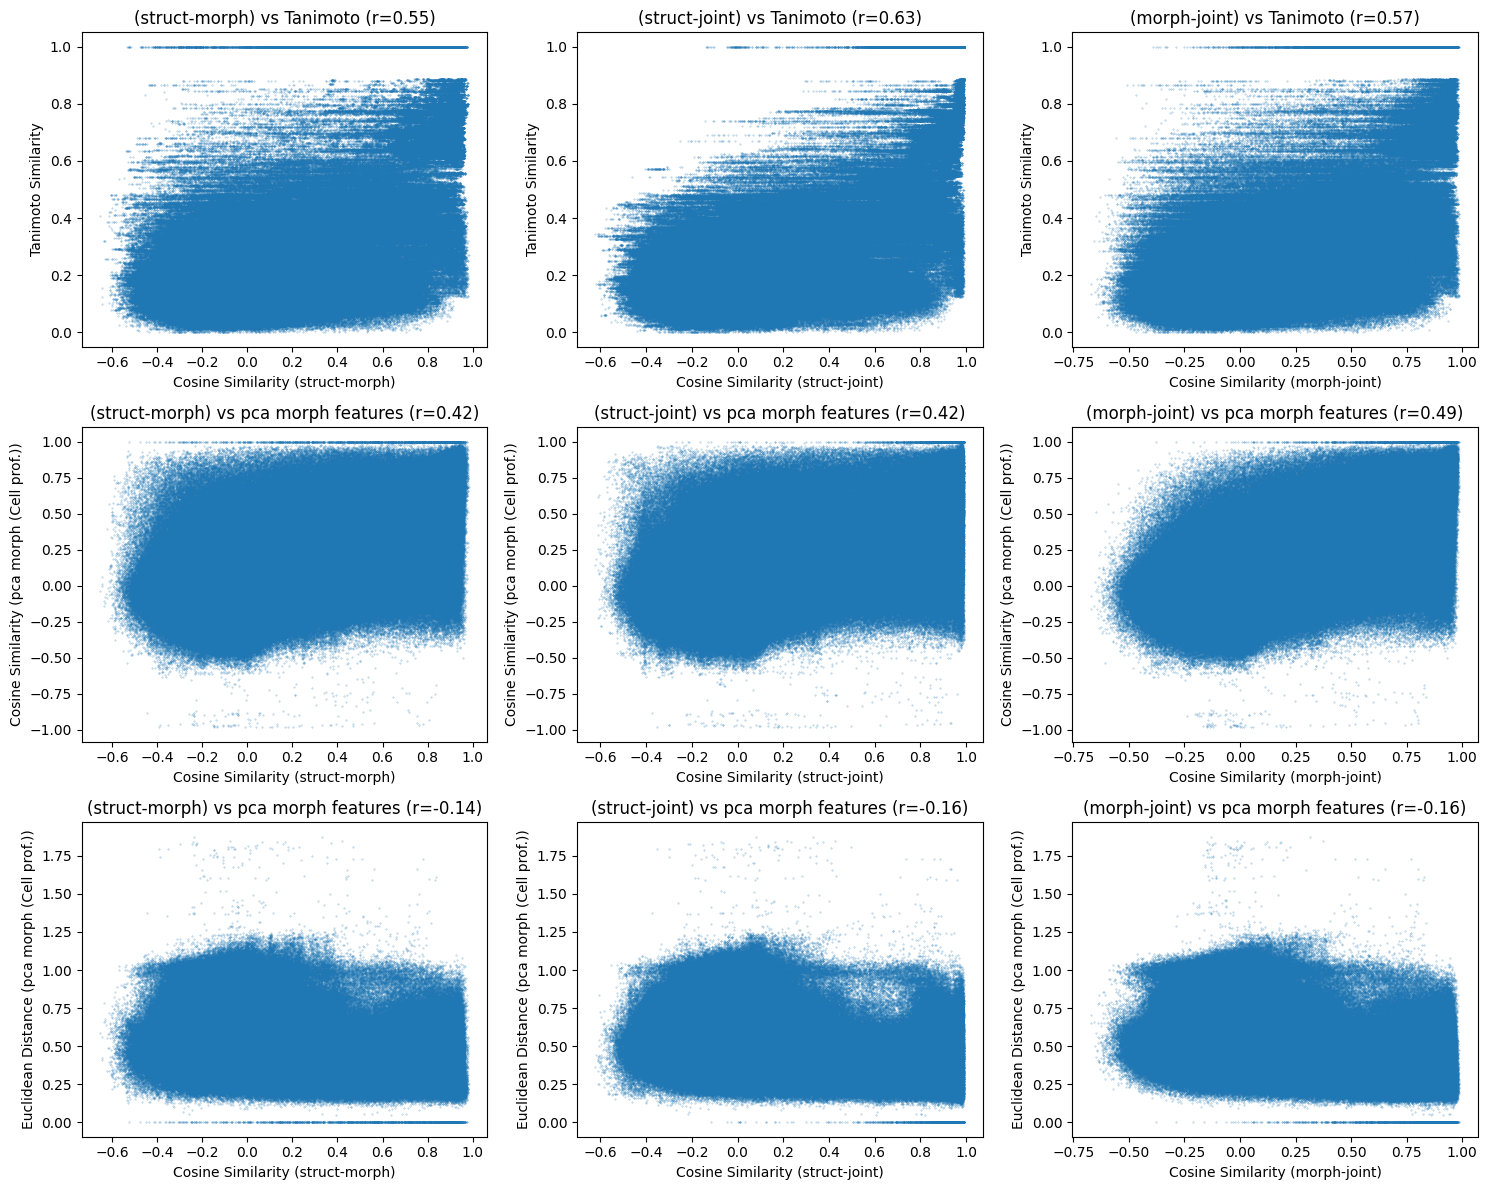

In [17]:
# plot cross-modality latent similarity versus PCA morph data
mods_x = ['struct', 'morph', 'joint']
morph_pca_sim_cos = get_pairwise_similarity(morph_pca, morph_pca, metric="cosine")
morph_pca_sim_euc = get_pairwise_similarity(morph_pca, morph_pca, metric="euclidean")

fig, ax = plt.subplots(3, 3, figsize=(15, 12))

for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    x, y = get_values_from_dist_mat(x, tanimoto_sim, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[0, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[0, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[0, idx].set_ylabel("Tanimoto Similarity")
    ax[0, idx].set_title(f"({mod_a}-{mod_b}) vs Tanimoto (r={corr[0, 1]:.2f})")
    
for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = morph_pca_sim_cos
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[1, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[1, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[1, idx].set_ylabel("Cosine Similarity (pca morph (Cell prof.))")
    ax[1, idx].set_title(f"({mod_a}-{mod_b}) vs pca morph features (r={corr[0, 1]:.2f})")
    
for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = morph_pca_sim_euc
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[2, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[2, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[2, idx].set_ylabel("Euclidean Distance (pca morph (Cell prof.))")
    ax[2, idx].set_title(f"({mod_a}-{mod_b}) vs pca morph features (r={corr[0, 1]:.2f})")
        
plt.tight_layout()
plt.savefig("cross_modality_vs_pca_morph.png")
plt.show()

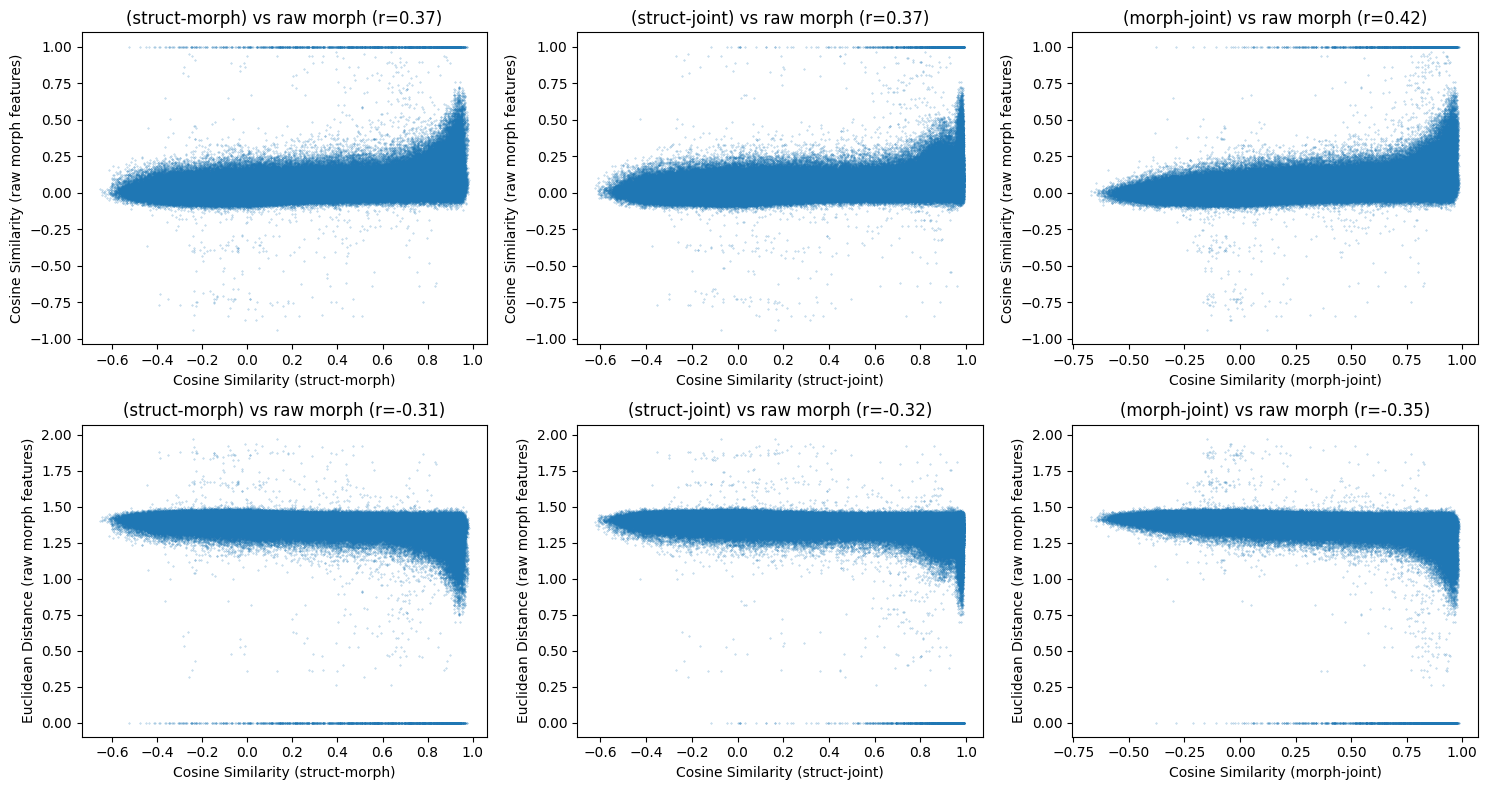

In [18]:
# plot cross-modality latent similarity versus raw morph domain distance
mods_x = ['struct', 'morph', 'joint']
morph_sim_cos = get_pairwise_similarity(morph, morph, metric="cosine")
morph_sim_euc = get_pairwise_similarity(morph, morph, metric="euclidean")

fig, ax = plt.subplots(2, 3, figsize=(15, 8))

for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = morph_sim_cos
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[0, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[0, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[0, idx].set_ylabel(f"Cosine Similarity (raw morph features)")
    ax[0, idx].set_title(f"({mod_a}-{mod_b}) vs raw morph (r={corr[0, 1]:.2f})")
    
for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = morph_sim_euc
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[1, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[1, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[1, idx].set_ylabel(f"Euclidean Distance (raw morph features)")
    ax[1, idx].set_title(f"({mod_a}-{mod_b}) vs raw morph (r={corr[0, 1]:.2f})")
        
plt.tight_layout()
plt.savefig("cross_modality_vs_raw_morph.png")
plt.show()

In [ ]:
# plot cross-modality latent similarity versus PCA gene expression
mods_x = ['struct', 'ge', 'joint']
ge_pca_sim_cos = get_pairwise_similarity(ge_pca, ge_pca, metric="cosine")
ge_pca_sim_euc = get_pairwise_similarity(ge_pca, ge_pca, metric="euclidean")

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
    
for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = ge_pca_sim_cos
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[0, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[0, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[0, idx].set_ylabel(f"Cosine Similarity (PCA gene exp, n={N_genes})")
    ax[0, idx].set_title(f"({mod_a}-{mod_b}) vs pca GE (r={corr[0, 1]:.2f})")
    
for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = ge_pca_sim_euc
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[1, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[1, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[1, idx].set_ylabel(f"Euclidean Distance (PCA gene exp, n={N_genes})")
    ax[1, idx].set_title(f"({mod_a}-{mod_b}) vs pca GE (r={corr[0, 1]:.2f})")
        
plt.tight_layout()
plt.savefig("cross_modality_vs_pca_ge.png")
plt.show()

In [ ]:
# Run same analysis as above, but with the top-k=81 most differentially expressed genes obtained from file
mods_x = ['struct', 'ge', 'joint']
filtered_ge_sim_cos = get_pairwise_similarity(filtered_ge, filtered_ge, metric="cosine")
filtered_ge_sim_euc = get_pairwise_similarity(filtered_ge, filtered_ge, metric="euclidean")
# filtered_ge_sim_mse = get_pairwise_similarity(filtered_ge, filtered_ge, metric="mse")

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
    
for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = filtered_ge_sim_cos
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[0, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[0, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[0, idx].set_ylabel(f"Cosine Similarity (DE gene exp, n=81)")
    ax[0, idx].set_title(f"({mod_a}-{mod_b}) vs filtered GE (r={corr[0, 1]:.2f})")
    
for idx, (mod_a, mod_b) in enumerate(itertools.combinations(mods_x, 2)):
    x = get_pairwise_similarity(
        p_representations[mod_a],
        p_representations[mod_b],
        metric="cosine"
    )
    y = filtered_ge_sim_euc
    x, y = get_values_from_dist_mat(x, y, keep_diag=True)
    corr = np.corrcoef(x, y)

    ax[1, idx].scatter(x, y, alpha=0.5, s=.1)
    ax[1, idx].set_xlabel(f"Cosine Similarity ({mod_a}-{mod_b})")
    ax[1, idx].set_ylabel(f"Euclidean Distance (DE gene exp, n=81)")
    ax[1, idx].set_title(f"({mod_a}-{mod_b}) vs filtered GE (r={corr[0, 1]:.2f})")
        
plt.tight_layout()
plt.savefig("cross_modality_vs_filtered_ge_top_81.png")
plt.show()

## Sanity Checks

In [6]:
from sklearn import preprocessing

In [11]:
filtered_ge = np.load("adata_scale_filt.npy")
scaled_filtered_ge = preprocessing.normalize(filtered_ge, axis=1)
filtered_test_ge = filtered_ge[test_idx]

In [6]:
loader = make_eval_data_loader(datamodule.dataset)
mods = unroll_dataloader(loader, mods=['ge', 'morph'])
ge = mods['ge']

100%|██████████| 133/133 [00:47<00:00,  2.83it/s]


In [14]:
# Check that there is overlap in the gene expression columns between the DE gene subset and the original
print(filtered_ge.shape, ge.shape)

de_idx = []

for col_1 in tqdm(filtered_ge.T):
    for idx, col_2 in enumerate(ge.T):
        if np.array_equal(col_1, col_2):
            de_idx.append(idx)
            
len(de_idx)

(16978, 81) (16978, 977)


100%|██████████| 81/81 [00:05<00:00, 16.15it/s]


0

In [7]:
# Compute mean and std deviation of the raw gene expression
u = np.mean(ge)
v = np.std(ge)

nu = np.mean(filtered_ge)
nv = np.std(filtered_ge)

snu = np.mean(scaled_filtered_ge)
snv = np.std(scaled_filtered_ge)

print(u, nu)
print(v, nv)

NameError: name 'filtered_ge' is not defined

In [16]:
print(np.linalg.norm(ge[0]))
print(np.linalg.norm(filtered_ge[0]))
print(np.linalg.norm(scaled_filtered_ge[0]))

1.0
7.520923341862967
1.0


In [17]:
# Plot histogram of pairwise distances in the raw gene expression space versus the filtered gene expression space
ge_dist = get_pairwise_similarity(ge, ge, metric="euclidean")
filtered_ge_dist = get_pairwise_similarity(filtered_ge, filtered_ge, metric="euclidean")

In [18]:
x, y = get_values_from_dist_mat(ge_dist, filtered_ge_dist)
x.shape, y.shape

((144117753,), (144117753,))

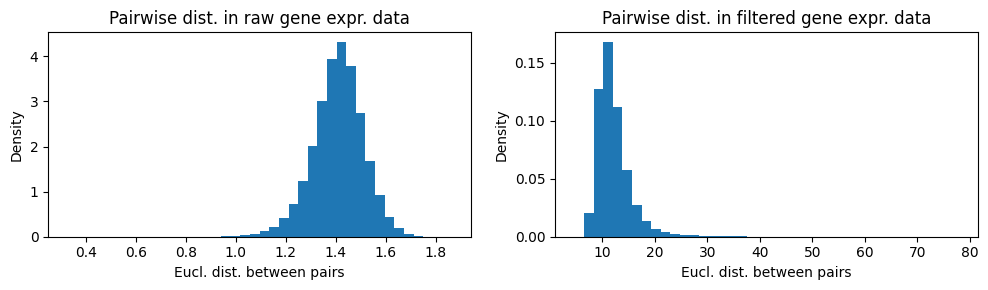

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].hist(x, density=True, bins=40)
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Eucl. dist. between pairs')
ax[0].set_title('Pairwise dist. in raw gene expr. data')

ax[1].hist(y, density=True, bins=40)
ax[1].set_ylabel('Density')
ax[1].set_xlabel('Eucl. dist. between pairs')
ax[1].set_title('Pairwise dist. in filtered gene expr. data')

plt.tight_layout()
plt.show()

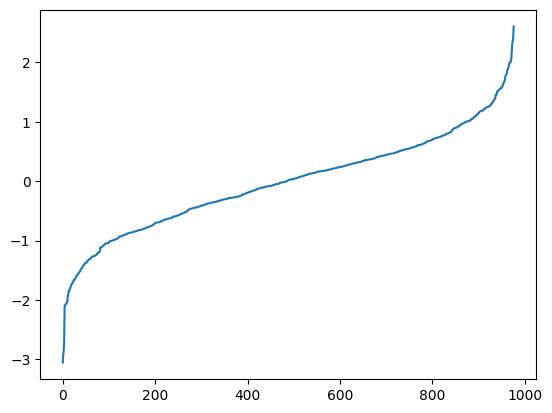

In [8]:
plt.plot(np.sort(ge[0]))
plt.show()

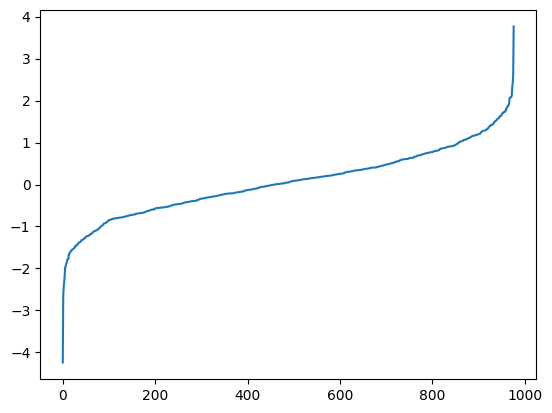

In [9]:
plt.plot(np.sort(ge[1]))
plt.show()